# Image Stitching

* Stitch two images using OpenCV by estimating homography

* use the high-level stitching API for stitching provided by
    * `cv::Stitcher`


## OpenCV

(pytorch)$ conda install -c conda-forge py-opencv

In [6]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import argparse
import sys

plt.rcParams['figure.figsize'] = [16, 9]



## Image Stitching

* Feature detection
* Feature matching & homography estimation using RANSAC
* align two images using estimated homography
* Stitching

How can we remove this seam?

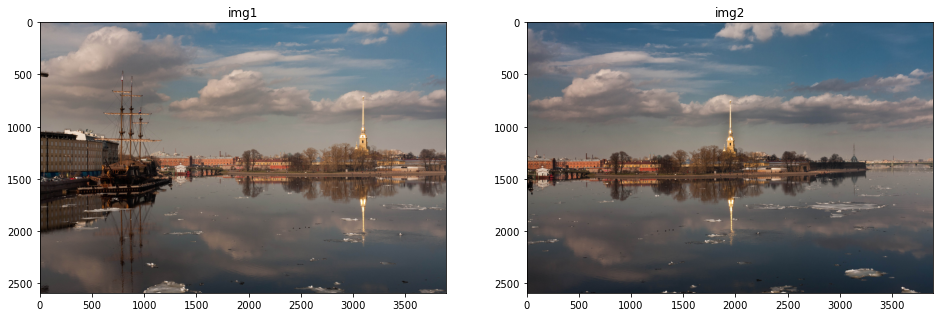

In [7]:
# read images
img_names = ['boat1.jpg','boat2.jpg']
img1 = cv.imread(img_names[0])
img2 = cv.imread(img_names[1])

plt.subplot(1,2,1), plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB)), plt.title('img1')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB)), plt.title('img2')
plt.show()

In [8]:
# Initiate SIFT detector
# TODO
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT (mask=None)
# TODO
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

### Visualize Features

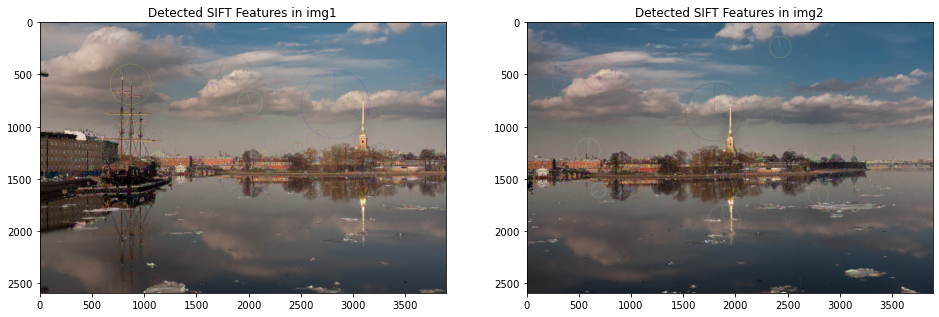

In [9]:
img1_vis = np.zeros_like(img1)
img2_vis = np.zeros_like(img2)

img1_vis = cv.drawKeypoints(img1, kp1, img1_vis, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_vis = cv.drawKeypoints(img2, kp2, img2_vis, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplot(1,2,1), plt.imshow(cv.cvtColor(img1_vis, cv.COLOR_BGR2RGB)), plt.title('Detected SIFT Features in img1')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(img2_vis, cv.COLOR_BGR2RGB)), plt.title('Detected SIFT Features in img2')
plt.show()

### Feature matching

In [10]:
# For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) # First one is IndexParams. For various algorithms, the information to be passed is explained in FLANN docs.
search_params = dict(checks=50) # Second dictionary is the SearchParams. It specifies the number of times the trees in the index should be recursively traversed. Higher values gives better precision, but also takes more time.

# Create FLANN based matcher
# TODO
matcher = cv.FlannBasedMatcher(index_params, search_params)

# compute k best matches (k=2)
# TODO
matches = matcher.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
# matches.distance - Distance between descriptors. The lower, the better it is.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance: # Lowe's ratio test.
        good.append(m)

print(len(good))

3543


* Draw matched points:

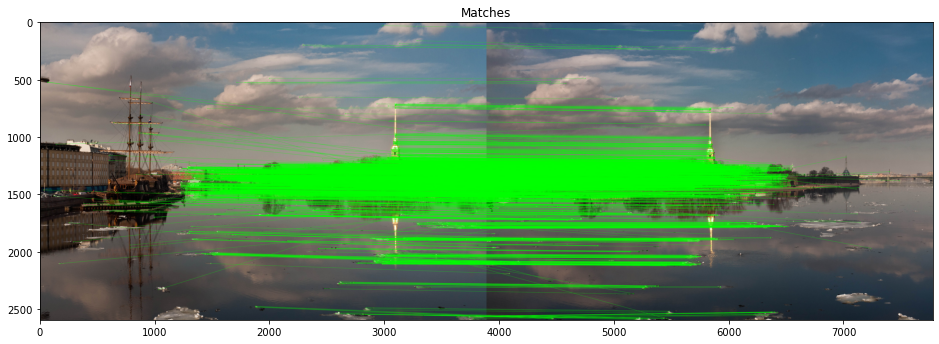

In [11]:
# draw matches
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img_matches = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

plt.imshow(cv.cvtColor(img_matches,cv.COLOR_BGR2RGB)), plt.title('Matches')
plt.show()

### Find Homography

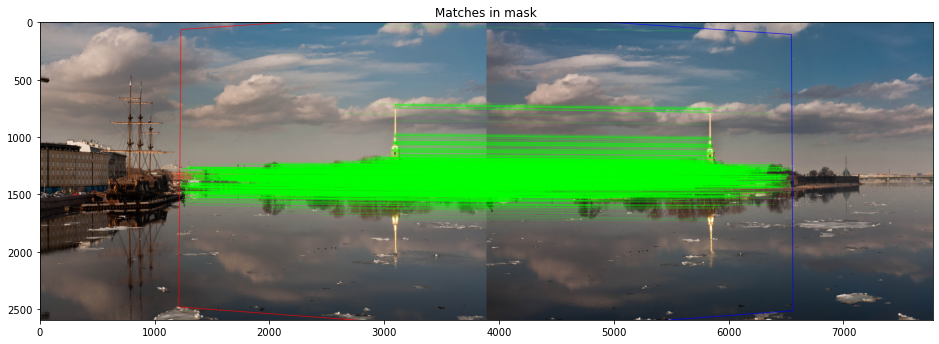

In [12]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:

    # find homography (method=cv2.RANSAC, ransacReprojThreshold=5.0)
    # TODO
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # perspective transform
    h, w, c = img1.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst1 = cv.perspectiveTransform(pts, M)

    h, w, c = img2.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst2 = cv.perspectiveTransform(pts, np.linalg.inv(M))

    img2_poly = cv.polylines(img2.copy(), [np.int32(dst1)], True, (255,0,0), 3, cv.LINE_AA)
    img1_poly = cv.polylines(img1.copy(), [np.int32(dst2)], True, (0,0,255), 3, cv.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

# draw matches
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

img3 = cv.drawMatches(img1_poly, kp1, img2_poly, kp2, good, None, **draw_params)

plt.imshow(cv.cvtColor(img3,cv.COLOR_BGR2RGB)), plt.title('Matches in mask')
plt.show()

### Image stitching

- `np.eye(3)` $= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$
- what does `A` do?

In [17]:
# define output image space
out_width = img2.shape[1]*2
out_height = img2.shape[0]*2
I = np.eye(3)
A = np.eye(3)
A[0:2,2] = [out_width//4, out_height//4] # width, heigh
# get inv(M)
# TODOt

# define mask
mask1 = np.ones_like(img1)
mask2 = np.ones_like(img2)

# get inv(M)
# TODO
M_inv = np.linalg.inv(M)

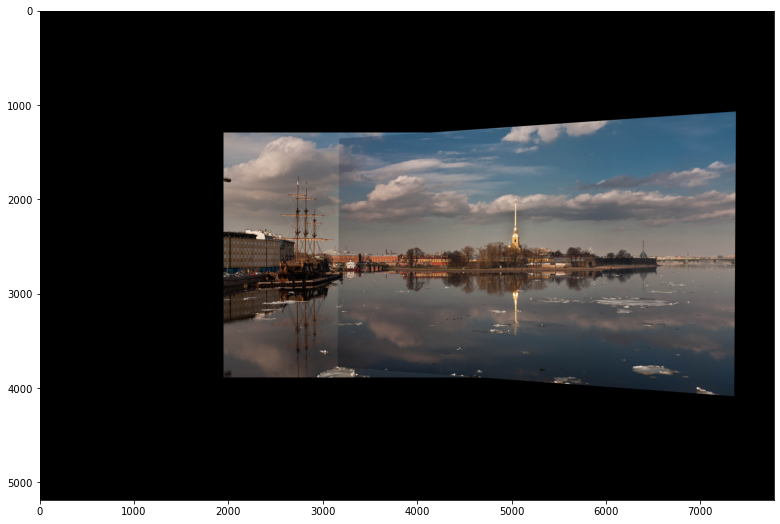

In [18]:
# warp img2 into output space with img1 camera pose (use M=A@M_inv, dsize=(out_width, out_height))
# TODO

img2_out = cv.warpPerspective(img2, A@M_inv, (out_width, out_height))
mask2_out = cv.warpPerspective(mask2, A@M_inv, (out_width, out_height))

# warp img1 into output space (use M=A, dsize=(out_width, out_height))
img1_out = cv.warpPerspective(img1, A@I, (out_width, out_height))
mask1_out = cv.warpPerspective(mask1, A@I, (out_width, out_height))

# stitch images
# alpha blending
img_stitch = img1_out
img_stitch = (1-mask2_out) * img_stitch +  mask2_out * img2_out


# display
img_stitch = np.clip(img_stitch,0,255).astype(np.uint8)
plt.imshow(cv.cvtColor(img_stitch, cv.COLOR_BGR2RGB))
plt.show()


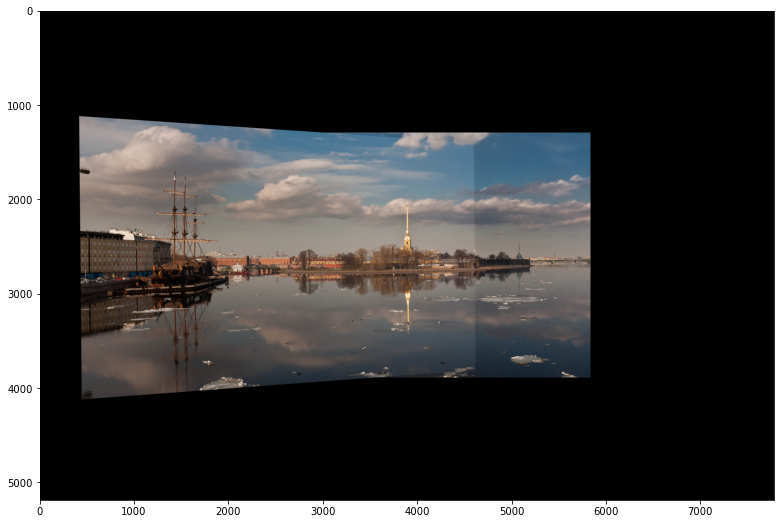

In [19]:
# warp img1 into output space with img2 camera pose (use M=A@M_inv, dsize=(out_width, out_height))
# TODO
img1_out = cv.warpPerspective(img1, A@M, (out_width, out_height))
mask1_out = cv.warpPerspective(mask1, A@M, (out_width, out_height))

# warp img2 into output space (use M=A, dsize=(out_width, out_height))
img2_out = cv.warpPerspective(img2, A@I, (out_width, out_height))
mask2_out = cv.warpPerspective(mask2, A@I, (out_width, out_height))

# stitch images
# alpha blending
img_stitch = img2_out
img_stitch = (1-mask1_out) * img_stitch +  mask1_out * img1_out

# display
img_stitch = np.clip(img_stitch,0,255).astype(np.uint8)
plt.imshow(cv.cvtColor(img_stitch, cv.COLOR_BGR2RGB))
plt.show()

## High-level stitching API

`cv::Stitcher::create` can create stitcher in one of the predefined configurations (argument mode).
See `cv::Stitcher::Mode` for details.
These configurations will setup multiple stitcher properties to operate in one of predefined scenarios.
After you create stitcher in one of predefined configurations you can adjust stitching by setting any of the stitcher properties.

Done


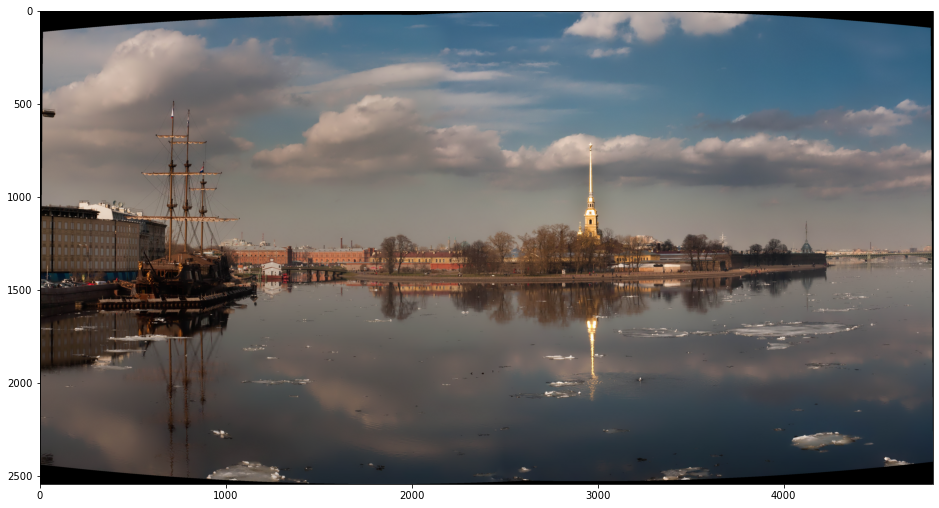

In [20]:
# read input images
img_names = ['boat1.jpg','boat2.jpg']

imgs = []
for img_name in img_names:
    img = cv.imread(cv.samples.findFile(img_name))
    if img is None:
        print("can't read image " + img_name)
        sys.exit(-1)
    imgs.append(img)


# create stitcher and stitch given images
stitcher = cv.Stitcher.create(mode = cv.Stitcher_PANORAMA)
status, pano = stitcher.stitch(imgs)


if status != cv.Stitcher_OK:
    print("Can't stitch images, error code = %d" % status)
    sys.exit(-1)
print('Done')


plt.imshow(cv.cvtColor(pano,cv.COLOR_BGR2RGB))
plt.show()

## Homework
- Stitch 3 images, instead of 2 images.
- Use your own sample images.
- Do not use `cv.Stitcher`!
